In [4]:
import os
import numpy as np
import pandas as pd
import argparse
from tqdm import tqdm
from random import shuffle
from music21 import *
from glob import glob
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, Dropout
from keras.utils import np_utils

%run lstm_model.ipynb
%run data_preprocess.ipynb
%run generate_music.ipynb

# configure.run()
# environment.set('musescoreDirectPNGPath', 'C:\\Program Files (x86)\\MuseScore 2\\bin\\MuseScore.exe')

np.set_printoptions(threshold=1000000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
bach_chorale_path = 'datasets/bach2'
parts_index = [0,1,2,3]
#parts_index = [0]
note_type = set()
"""
note_type:
0-127 : note pitch
128: slur-1st-part
129: slur-2nd-part
130: slur-3rd-part
131: slur-4th-part
132: rest
133: start symbol
134: end symbol
"""

def filter_files(files):
    file_list = []
    file_count = 0
    for i, file in enumerate(files, 1):
        s = converter.parse(file)
        if len(s.parts) == len(parts_index):
            print(i, file, len(s.parts))
            file_count += 1
            file_list.append(file)
    return file_list, file_count

def make_note_type_list():
    note_type_list = []
    for i in note_type:
        note_type_list.append(i)
    return sorted(note_type_list)

def index_note_transform(inputs, option, part_number):
    transformed_inputs = []
    if option == "to_note":
        note_dict = dict((index, note) for index, note in enumerate(note_type))
    elif option == "to_index":
        note_dict = dict((note, index) for index, note in enumerate(note_type))
    #print(inputs.shape)
    for p_index in range(part_number):
        transformed_part = []
        for n in range(inputs.shape[1]):
            for keys in note_dict:
                if option == "to_note":
                    if inputs[p_index][n] == keys:
                        transformed_part.append(note_dict[keys])
                elif option == "to_index":
                    if frozenset(inputs[p_index][n]) == keys:
                        transformed_part.append(note_dict[keys])
        transformed_inputs.append(transformed_part)
    return np.array(transformed_inputs)
def notes_to_piano_roll(dataset_notes):
    note_type.add(frozenset([133]))
    note_type.add(frozenset([134]))
    for chorale_index in range(len(dataset_notes)):
        chorale = np.array(dataset_notes[chorale_index])
        
#         for i in range(len(parts_index)):
#             piano_roll_notes.append(np.concatenate((start_symbol, chorale[i], end_symbol)))
        chorale = index_note_transform(chorale, "to_index", len(parts_index))
        piano_roll_notes = np.transpose(chorale)
        yield piano_roll_notes
def notes_to_onehot(notes):
    note_dict = dict((index, note) for index, note in enumerate(note_type))
    onehot = []
    for i, n in enumerate(notes):
        l = []
        for note in n:
            l.append(np.array(note == np.arange(0, len(note_dict)), dtype=np.int32))
        onehot.append(l)
    return np.array(onehot)
def part_notes_to_onehot(notes):
    note_dict = dict((index, note) for index, note in enumerate(note_type))
    onehot = []
    for i, n in enumerate(notes):
        l = np.zeros(len(note_dict,), dtype=np.int32)
        for note in n:
            l[note] = 1
        onehot.append(l)
    return np.array(onehot)

def split_data(chorale_list):
    X_train = chorale_list[0]
    X_test = chorale_list[int(len(chorale_list) * 0.8)]
    notes = chorale_list[0]
    
    for i, n in enumerate(chorale_list):
        if i != 0:
            notes = np.concatenate((notes, n))
            if i < int(len(chorale_list) * 0.8):
                X_train = np.concatenate((X_train, n))
            elif i > int(len(chorale_list) * 0.8):
                X_test = np.concatenate((X_test, n))
    print(X_train.shape, X_test.shape, notes.shape)
    
    X_train_onehot_notes = part_notes_to_onehot(X_train)
    X_test_onehot_notes = part_notes_to_onehot(X_test)
    Y_train_onehot_notes = notes_to_onehot(X_train)
    Y_test_onehot_notes = notes_to_onehot(X_test)
    onehot_notes = part_notes_to_onehot(notes)
    
    return X_train_onehot_notes, X_test_onehot_notes, Y_train_onehot_notes, Y_test_onehot_notes, onehot_notes
def load_files():
    if os.path.exists(bach_chorale_path):
        file_list, num_file = filter_files(glob(bach_chorale_path + '/*.mxl') +
                                 glob(bach_chorale_path + '/*.mid'))
        return file_list, num_file
    else:
        print("The file path is wrong!!")

def fill_list(chords):
    if len(chords) < len(parts_index):
        for i in range(len(parts_index) - len(chords)):
            chords.append(frozenset([128]))
    return chords
def analyze_harmony(chorale_list, chorale_key_list):
    chorale_list = np.array(chorale_list)
    not_note_list = [128, 129, 130, 131, 132, 133, 134]
    chord_type_list = [] # Ex: I, VI, ii
    chord_list = [] 
    #print(len(chorale_key_list),chorale_key_list)
    for i, chorale in enumerate(chorale_list):
        chorale_notes = index_note_transform(np.array(chorale), "to_note", len(chorale))
        
        chorale_notes_list = []
        chord_type = []
        for j, t_notes in enumerate(chorale_notes): # Iterate over each time unit
            note_list = []
            
            for part_notes in t_notes: # Iterate over notes in each part 
                for n in part_notes:
                    if n not in not_note_list:
                        note_list.append(n)
            if len(note_list) != 0:
                _chord = chord.Chord(note_list)
                chorale_key = chorale_key_list[i]
                rf = roman.romanNumeralFromChord(_chord, chorale_key) # [chord, key]
                #print(rf.figure, chorale_key.tonicPitchNameWithCase)
                chord_type.append({chorale_key.tonicPitchNameWithCase : rf.figure})
                #tonicPitchNameWithCase: Return the pitch name as a string with the proper case (upper = major; lower = minor)
                chord_degree_and_key = roman.RomanNumeral(rf.figure, chorale_key.tonicPitchNameWithCase)
                chords = [frozenset([c.midi]) for c in chord_degree_and_key.pitches]
                chords = fill_list(chords)
                if len(chords) == len(parts_index):
                    chord_list.append(chords)
                
                #print(chords)
                #display_notes.show()
            chorale_notes_list.append(note_list)
        chord_type_list.append(chord_type)
        chorale_list[i] = np.array(chorale_notes_list)
    chord_list = np.transpose(chord_list)    
    print(chord_list.shape)
    print(chord_list)
    midi = chorale_to_midi(chorale_list)
    chord_list = index_note_transform(np.array(chord_list), "to_index", len(parts_index))
    
    output_file = 'TEST.mid'
    make_midi_file(output_file, midi)

def main():
#     parser = argparse.ArgumentParser(description='**********************')
#     parser.add_argument('-t', '--train')
#     parser.add_argument('-g', '--generate', help='generate music with trained model')
#     args = parser.parse_args()
    train = True
    file_list, num_file = load_files()
    print(num_file)
    dataset_notes, chorale_key_list = make_dataset(file_list)
    shuffle(dataset_notes)
    chorale_list = [notes for chorale_index, notes in enumerate(notes_to_piano_roll(dataset_notes))]
   
    #analyze_harmony(chorale_list, chorale_key_list)
    X_train_onehot_notes, X_test_onehot_notes, Y_train_onehot_notes, Y_test_onehot_notes, onehot_notes = split_data(chorale_list)
    epochs = 20
    if train:
        for i in range(len(parts_index)): 
            lstm_model = LSTM_Model(X=X_train_onehot_notes,Y=Y_train_onehot_notes,
                                    num_units=128, epochs=epochs, output_dim=len(note_type), name="bach"+str(i))
            gen = ((X,Y) for (X, Y) in lstm_model.generator(X_train_onehot_notes, Y_train_onehot_notes, i))
            test_gen = ((X,Y) for (X,Y) in lstm_model.generator(X_test_onehot_notes, Y_test_onehot_notes, i))
            lstm_model.model2()
            lstm_model.train_model(gen, test_gen)
    print(onehot_notes.shape)
    score = generate_notes(X_test_onehot_notes, note_type)
                
    output_file = str(epochs) + '-epochs_' + str(num_file) + '-samples4.mid'
    make_midi_file(output_file, score)
if __name__ == "__main__":
    main()

1 datasets/bach2\bach_21.mid 4
2 datasets/bach2\bach_22.mid 4
3 datasets/bach2\bach_23.mid 4
5 datasets/bach2\bach_25.mid 4
6 datasets/bach2\bach_26.mid 4
7 datasets/bach2\bach_27.mid 4
9 datasets/bach2\bach_289.mid 4
10 datasets/bach2\bach_29.mid 4
11 datasets/bach2\bach_290.mid 4
12 datasets/bach2\bach_291.mid 4
13 datasets/bach2\bach_292.mid 4
14 datasets/bach2\bach_293.mid 4
15 datasets/bach2\bach_294.mid 4
16 datasets/bach2\bach_295.mid 4
17 datasets/bach2\bach_296.mid 4
18 datasets/bach2\bach_297.mid 4
19 datasets/bach2\bach_298.mid 4
20 datasets/bach2\bach_299.mid 4
22 datasets/bach2\bach_300.mid 4
23 datasets/bach2\bach_301.mid 4
24 datasets/bach2\bach_302.mid 4
25 datasets/bach2\bach_303.mid 4
26 datasets/bach2\bach_304.mid 4
27 datasets/bach2\bach_305.mid 4
28 datasets/bach2\bach_306.mid 4
29 datasets/bach2\bach_307.mid 4
30 datasets/bach2\bach_308.mid 4
31 datasets/bach2\bach_309.mid 4
32 datasets/bach2\bach_31.mid 4
33 datasets/bach2\bach_310.mid 4
34 datasets/bach2\bach_31

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [03:06<00:00,  2.08s/it]


740
(170476, 4) (41684, 4) (212160, 4)
Another model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 49)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 200)           200000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 200)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 16, 200)           40200     
_________________________________________________________________
dense_2 (Dense)              (None, 16, 49)            9849      
Total params: 250,049
Trainable params: 250,049
Non-trainable params: 0
_________________________________________________________________
train model...
Epoch 1/20
7s - loss: 1.3813 - val_loss: 2.6564
Epoch 2/20
5s - l

{0: frozenset({49}), 1: frozenset({38}), 2: frozenset({79}), 3: frozenset({77}), 4: frozenset({50}), 5: frozenset({75}), 6: frozenset({72}), 7: frozenset({78}), 8: frozenset({68}), 9: frozenset({63}), 10: frozenset({44}), 11: frozenset({59}), 12: frozenset({56}), 13: frozenset({133}), 14: frozenset({131}), 15: frozenset({128}), 16: frozenset({70}), 17: frozenset({57}), 18: frozenset({53}), 19: frozenset({58}), 20: frozenset({51}), 21: frozenset({48}), 22: frozenset({65}), 23: frozenset({54}), 24: frozenset({76}), 25: frozenset({130}), 26: frozenset({41}), 27: frozenset({39}), 28: frozenset({42}), 29: frozenset({60}), 30: frozenset({61}), 31: frozenset({73}), 32: frozenset({62}), 33: frozenset({71}), 34: frozenset({52}), 35: frozenset({69}), 36: frozenset({74}), 37: frozenset({67}), 38: frozenset({64}), 39: frozenset({134}), 40: frozenset({47}), 41: frozenset({45}), 42: frozenset({43}), 43: frozenset({40}), 44: frozenset({46}), 45: frozenset({55}), 46: frozenset({36}), 47: frozenset({12

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide


       (49)  (38)  (79)      (77)  (50)      (75)      (72)  (78)  (68)  (63)  \
(49)    NaN   NaN   NaN  0.000000   NaN  0.000000  0.000000   NaN   0.0   0.0   
(38)    NaN   NaN   NaN  0.000000   NaN  0.000000  0.000000   NaN   0.0   0.0   
(79)    NaN   NaN   NaN  0.000000   NaN  0.000000  0.000000   NaN   0.0   0.0   
(77)    NaN   NaN   NaN  0.000000   NaN  0.013158  0.000000   NaN   0.0   0.0   
(50)    NaN   NaN   NaN  0.000000   NaN  0.000000  0.000000   NaN   0.0   0.0   
(75)    NaN   NaN   NaN  0.014493   NaN  0.000000  0.002439   NaN   0.0   0.0   
(72)    NaN   NaN   NaN  0.000000   NaN  0.000000  0.000000   NaN   0.0   0.0   
(78)    NaN   NaN   NaN  0.000000   NaN  0.000000  0.000000   NaN   0.0   0.0   
(68)    NaN   NaN   NaN  0.000000   NaN  0.000000  0.000000   NaN   0.0   0.0   
(63)    NaN   NaN   NaN  0.000000   NaN  0.000000  0.000000   NaN   0.0   0.0   
(44)    NaN   NaN   NaN  0.000000   NaN  0.000000  0.000000   NaN   0.0   0.0   
(59)    NaN   NaN   NaN  0.0

(66)    NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   0.0  
File TTTTT.mid written
(1000, 16, 49)
{0: frozenset({49}), 1: frozenset({38}), 2: frozenset({79}), 3: frozenset({77}), 4: frozenset({50}), 5: frozenset({75}), 6: frozenset({72}), 7: frozenset({78}), 8: frozenset({68}), 9: frozenset({63}), 10: frozenset({44}), 11: frozenset({59}), 12: frozenset({56}), 13: frozenset({133}), 14: frozenset({131}), 15: frozenset({128}), 16: frozenset({70}), 17: frozenset({57}), 18: frozenset({53}), 19: frozenset({58}), 20: frozenset({51}), 21: frozenset({48}), 22: frozenset({65}), 23: frozenset({54}), 24: frozenset({76}), 25: frozenset({130}), 26: frozenset({41}), 27: frozenset({39}), 28: frozenset({42}), 29: frozenset({60}), 30: frozenset({61}), 31: frozenset({73}), 32: frozenset({62}), 33: frozenset({71}), 34: frozenset({52}), 35: frozenset({69}), 36: frozenset({74}), 37: frozenset({67}), 38: frozenset({64}), 39: frozenset({134}), 40: frozenset({47}), 41: frozenset({45}), 42: frozenset({43}), 

In [18]:
import numpy as np

sequence_length = 100
seq = np.zeros(shape=(2 * 16 + sequence_length, 4))
for expert_index in range(4):
    # Add start and end symbol + random init
    seq[16:-16, expert_index] = np.random.randint(73,size=sequence_length)
seq

note_type = [1,3,6,12,35,67,82,11,32,99,1241,147]
note_dict = dict((index, note) for index, note in enumerate(note_type))
for i in note_dict:
    print(note_dict[i])

n = [1,2,5,12,12,12,12,3,7,9,9,9,9,2,2,14,151,6]
n = np.array(n)
b = [12,9]

new_arr = np.setdiff1d(n,b)
print(new_arr)
bb = set()
bb.add(7)
bb.add(2)
bb.add(3)
bb.add(6)
bb.add(7)
print(list(bb))


1
3
6
12
35
67
82
11
32
99
1241
147
[  1   2   3   5   6   7  14 151]
[2, 3, 6, 7]


In [17]:
from music21 import *
import numpy as np

for semi_tone in range(-7,7):
    interval_type, interval_nature = interval.convertSemitoneToSpecifierGeneric(semi_tone)
    transposition_interval = interval.Interval(str(interval_nature) + interval_type)
    print(transposition_interval)

<music21.interval.Interval P-5>
<music21.interval.Interval d-5>
<music21.interval.Interval P-4>
<music21.interval.Interval M-3>
<music21.interval.Interval m-3>
<music21.interval.Interval M-2>
<music21.interval.Interval m-2>
<music21.interval.Interval P1>
<music21.interval.Interval m2>
<music21.interval.Interval M2>
<music21.interval.Interval m3>
<music21.interval.Interval M3>
<music21.interval.Interval P4>
<music21.interval.Interval d5>


[  1.51893965   1.2188288  -10.61149442  -3.63057014  -2.95162459
  -1.73982169  -2.24195819   2.06409381   3.00441254  -5.65820463]


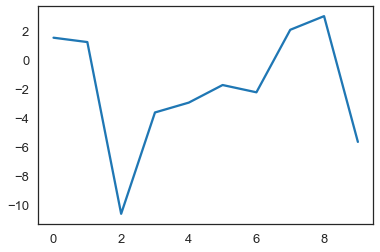

In [118]:
import numpy as np
import matplotlib.pyplot as plt

prob1 = np.random.normal(0,15,10)
prob2 = np.random.normal(100,15,1)
print(prob)
plt.plot(prob)
plt.show()

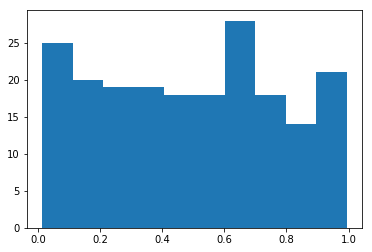

In [135]:
import numpy as np
import matplotlib.pyplot as plt

uni_prob_arr = []

for i in range(200):
    uni_prob = np.random.uniform(0,1,1)
    uni_prob_arr.append(np.random.uniform(0,1,1))
uni_prob_arr = np.array(uni_prob_arr)
plt.hist(uni_prob_arr)
plt.show()
# print(prob_arr)

[0.69646919 0.28613933 0.22685145 0.55131477 0.71946897 0.42310646
 0.9807642  0.68482974 0.4809319  0.39211752 0.34317802 0.72904971
 0.43857224 0.0596779  0.39804426 0.73799541 0.18249173 0.17545176
 0.53155137 0.53182759]


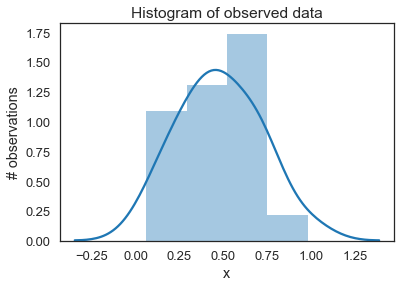

In [62]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)
data = np.random.rand(20)
print(data)

ax = plt.subplot()
sns.distplot(data)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations')